In [1]:
import numpy as np 

In [197]:
class Kernel(object):
    def __init__(self, theta=[], seed=42):
        np.random.seed(seed)
        if len(theta) != 4:
            self.theta = np.random.randn(4)  
        else:
            self.theta = np.array(theta)  
    
    def make_kernel(self, X):
        """
        inputs : 
            X : 2d-array. shape=[N, d].
        returns : 
            K : 2d-array. shape=[N,N]. 
                The matrix that represents covariance.
        """
        N = X.shape[0] 
        
        # make kernel matrix 
        K = np.zeros(shape=[N,N],dtype=float)
        for i in range(N):
            for j in range(N):
                K[i,j] = self._kernel(X[i], X[j], i, j)  
        return K 
                
    def _kernel(self, x, x_, n=0, n_=1):
        """
        inputs : 
            x : 1d-array. shape=[d]
            x_ : 1d-array. shape=[d]
            n, n_ : the index of data.
        returns: 
            k : scaler.
        """
        k_1 = self.theta[0] * np.exp(- np.sum((x - x_)**2) / self.theta[1]) 
        k_2 = self.theta[2] * np.sum((x - x_)**2)  
        k_3 = self.theta[3] * (n==n_) # delta function 
        return k_1 + k_2 + k_3 
    
    def part_k(self, x, x_, n, n_):
        """
        inputs: 
           x, x_ : 1d-array. shape=[d]
           n, n_ : the index of data
        returns: 
            dk : 1d-array. shape=[4].
                the result of dk/dθ
        """
        dk = np.zeros(4)
        dk[0] =  np.exp(- np.sum((x - x_)**2) / self.theta[1])   
        dk[1] = self.theta[0] * np.sum((x-x_)**2) / self.theta[1]**2 * np.exp(- np.sum((x - x_)**2) / self.theta[1])  
        dk[2] = np.sum((x - x_)**2)
        dk[3] = 1.0 * (n==n_)  # delta function
        return dk 
    
    def part_K(self, X):
        """
        inputs: 
           X : 2d-array. shape=[N, d].
        returns: 
           dK :3d-array. shape=[4, N, N,].
               the result of dK/dθ
        """
        N = X.shape[0]
        dK = np.zeros(shape=[N, N, 4])
        for i in range(N):
            for j in range(N):
                dK[i, j] =self. part_k(X[i], X[j], i, j)
        dK = dK.transpose(2, 0, 1)
        return dK
    
    def make_k_star(self, X, X_star):
        """
        inputs: 
            X : 2d-array.  The known values
            X_star: 2d-array. shape=[M,d]. The unkonwn values.
        returns: 
            k_star: 2d-array. shape=[N, M]
        """
        N = X.shape[0]
        M = X_star.shape[0]
        k_star = np.zeros((N, M))
        for i in range(N):
            for j in range(M):
                k_star[i,j] = self._kernel(X[i], X_star[j])
        return k_star 
        
                
        
            

In [312]:
class GPRegression(object):
    
    def __init__(self,kernel, thetas=[]):
        """
        inputs: 
            kernel : the class for kernel.
        """
        self.kernel = kernel(thetas)
        
    def fit(self, X, y, num_iter=10, eta=0.1):
        """
        In this process, optimize the hyper parameters.
        inputs: 
            X : 2d-array. shape=[N, d]
                The explanatory variables.
            y : 1d-array. shape=[N]
                The objective variables.
        returns: 
            None
        """
        self.X = X  
        self.y = y 
        
        # optimize thetas 
        for i in range(num_iter):
            dl = self.part_l() 
            self.kernel.theta += eta * dl  
        self.K = self.kernel.make_kernel(X) # kernel_matrix for predict to use for predicting value.
            
    def part_l(self):
        N = self.X.shape[0]
        k_theta = self.kernel.make_kernel(self.X)
        k_theta_inv = np.linalg.inv(k_theta)
        dk_dtheta = self.kernel.part_K(self.X)
        dl_1 = - np.trace(np.dot(dk_dtheta, k_theta_inv), axis1=1, axis2=2)
        dl_2_1 = (np.dot(k_theta_inv,y.reshape(-1,1))) 
        dl_2 = np.dot(np.dot(dl_2_1.T, dk_dtheta).reshape(4,N), dl_2_1) # -> [4,1]
        dl_2 = dl_2.flatten()
        return dl_1 + dl_2
    
    def predict(self, X_star):
        k_star = self.kernel.make_k_star(self.X, X_star)
        k_dstar = self.kernel.make_kernel(X_star)  
        K_inv = np.linalg.inv(self.K)
        m = np.dot(np.dot(k_star.T, K_inv), self.y.reshape(-1,1))
        v = k_dstar - np.dot(np.dot(k_star.T, K_inv), k_star)
        return m, v

In [368]:
gpr = GPRegression(Kernel, [1.0, 1.0, 1.0, 1.0])  

In [369]:
def truef(X):
    return np.exp(X-2.0) + 1.2

In [370]:
X = np.random.uniform(-3, 3, size=[40, 1])
y = truef(X)  + 0.2*np.random.randn(40,1)

In [371]:
import matplotlib.pyplot as plt 
%matplotlib inline 

In [372]:
gpr.fit(X,y,num_iter=20, eta=0.05)

In [373]:
X_star = np.linspace(-3, 3, 40).reshape(-1,1)
m, v = gpr.predict(X_star)
m = m.flatten()
print(np.diag(v))
v = np.diag(np.abs(v))

[7.18204271 6.46817331 6.01048455 5.73828337 5.59221272 5.52571373
 5.50495004 5.50743479 5.51979628 5.53519317 5.55084601 5.56601877
 5.58061475 5.59439393 5.60670806 5.61659534 5.62306928 5.62545916
 5.62369403 5.61845906 5.61118968 5.60390295 5.59889675 5.59836874
 5.60401529 5.61666588 5.63599898 5.66038361 5.68690681 5.71167862
 5.73053714 5.74027795 5.7404798  5.73587998 5.73908744 5.77325042
 5.87417844 6.09140612 6.48780447 7.13757853]


In [374]:
X_star.shape, m.shape, v.shape

((40, 1), (40,), (40,))

In [375]:
v

array([7.18204271, 6.46817331, 6.01048455, 5.73828337, 5.59221272,
       5.52571373, 5.50495004, 5.50743479, 5.51979628, 5.53519317,
       5.55084601, 5.56601877, 5.58061475, 5.59439393, 5.60670806,
       5.61659534, 5.62306928, 5.62545916, 5.62369403, 5.61845906,
       5.61118968, 5.60390295, 5.59889675, 5.59836874, 5.60401529,
       5.61666588, 5.63599898, 5.66038361, 5.68690681, 5.71167862,
       5.73053714, 5.74027795, 5.7404798 , 5.73587998, 5.73908744,
       5.77325042, 5.87417844, 6.09140612, 6.48780447, 7.13757853])

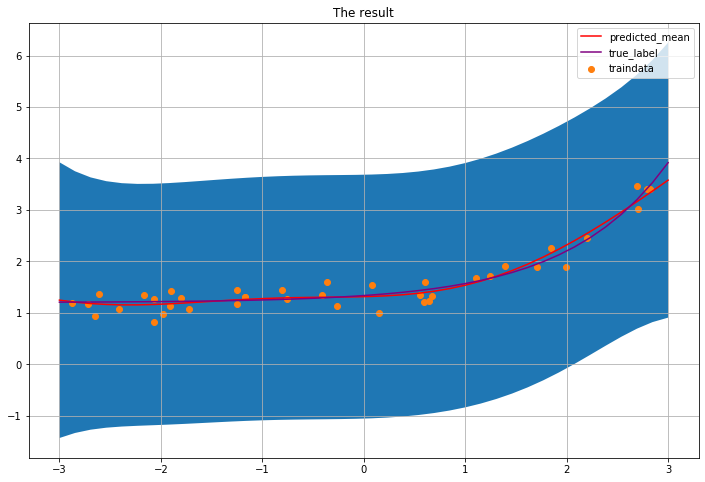

In [376]:
plt.figure(figsize=(12,8))
plt.title('The result')
plt.fill_between(X_star.flatten(), m-np.sqrt(v), m +np.sqrt(v))
plt.plot(X_star.flatten(), m , color='red', label='predicted_mean')
plt.scatter(X.flatten(), y.flatten(), label='traindata')
plt.plot(X_star.flatten(), truef(X_star.flatten()), label='true_label', color='purple')
plt.legend()
plt.grid()
plt.savefig('./results.png')

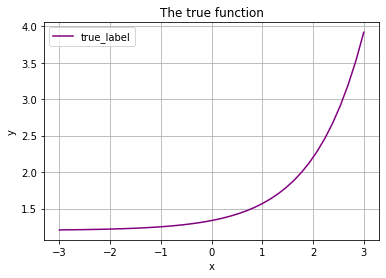

In [377]:
plt.plot(X_star.flatten(), truef(X_star.flatten()), label='true_label', color='purple')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('The true function')
plt.savefig("./true_func.png")

In [171]:
a = np.random.randn(1, 10)
b = np.random.randn(4,10,10)
np.dot(a,b).shape

(1, 4, 10)

In [96]:
a = np.random.randn(3)
np.tile(a, [2,1])

array([[-0.54438272,  0.11092259, -1.15099358],
       [-0.54438272,  0.11092259, -1.15099358]])